Import dependecies and data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from utils import *
from sklearn.metrics import mean_squared_error

# Define relevant paths
folder_path     = "comp_sweep_2"
excel_file_path = "stb_vert_trajectories.xlsx"


# List all files in the folder
files = os.listdir(folder_path)

# Create a dictionary to store the dataframes
ntrt_dataframes = {}

# Loop through the files and read them into dataframes
for file in files:
    file_path           = os.path.join(folder_path, file)
    df_name             = file.split('.')[0]
    ntrt_dataframes[df_name] = pd.read_csv(file_path, skiprows=1)

# Display the names of the dataframes
ntrt_dataframes.keys()

dict_keys(['_11172024_144831', '_11172024_145905', '_11172024_144950', '_11172024_145333', '_11172024_145737', '_11172024_145045', '_11172024_145723', '_11172024_145537', '_11172024_145245', '_11172024_145523', '_11172024_144826', '_11172024_145641', '_11172024_145319', '_11172024_145443', '_11172024_144946', '_11172024_145456', '_11172024_144748', '_11172024_145654', '_11172024_145132', '_11172024_145126', '_11172024_145250', '_11172024_145532', '_11172024_145240', '_11172024_145650', '_11172024_144758', '_11172024_145452', '_11172024_145309', '_11172024_145447', '_11172024_145137', '_11172024_145719', '_11172024_144836', '_11172024_145255', '_11172024_145519', '_11172024_144808', '_11172024_145727', '_11172024_145121', '_11172024_145848', '_11172024_145323', '_11172024_144941', '_11172024_144955', '_11172024_145646', '_11172024_145901', '_11172024_145054', '_11172024_145732', '_11172024_145040', '_11172024_144821', '_11172024_145741', '_11172024_145609', '_11172024_145812', '_1117202

Extract max simulation jump height

In [3]:
# Consider only restults after the jump occurs to ignore settling motion
release_time       = 5
sim_time           = ntrt_dataframes[list(ntrt_dataframes.keys())[0]]['time']
closest_time_index = (sim_time - release_time).abs().idxmin()

# Compute centroid to estimate CoM position
avg_pos_dataframes = {}
for name, df in ntrt_dataframes.items():
    avg_pos_dataframes[name] = extract_position_data(df)
    avg_pos_dataframes[name] = avg_pos_dataframes[name].iloc[closest_time_index:].reset_index(drop=True)

# Sort avg_pos_dataframes by when they were created (since they were simulated in increasing sweep order)
avg_pos_dataframes = dict(sorted(avg_pos_dataframes.items(), reverse=True))

# Extract the first 100 dataframes
avg_pos_dataframes = dict(list(avg_pos_dataframes.items())[:100])

# Extract max jump height
comps = np.linspace(0, 50, len(avg_pos_dataframes))
max_y = []
for name, df in avg_pos_dataframes.items():
    max_y.append(df['avg_y'].max())

# Convert to numpy array
max_y = np.array(max_y)

# Convert max height to displacement
sim_y_displacements = []
for i, (name, df) in enumerate(avg_pos_dataframes.items()):
    sim_y_displacements.append(max_y[i] - df['avg_y'][0])


Determine max experimental trajectory values

In [4]:

# Read the Excel file into a dictionary of DataFrames, one for each sheet
stb_vert_trajectories_dfs = pd.read_excel(excel_file_path, sheet_name=['46comp', '20comp', '30comp', '40comp'])

# Display the names of the sheets
stb_vert_trajectories_dfs.keys()

# Extract max y values for each test case and compute displacement
exp_y_displacements = {}
for sheet_name, df in stb_vert_trajectories_dfs.items():
    exp_y_displacements[sheet_name] = {col: df[col].max() - df[col][0] for col in df.columns if 'y' in col}

# Calculate the average and standard deviation of max_y_values
avg_exp_y_values = {comp: np.mean(list(values.values())) for comp, values in exp_y_displacements.items()}
std_exp_y_values = {comp: np.std(list(values.values())) for comp, values in exp_y_displacements.items()}

print(exp_y_displacements)

{'46comp': {'y1': 1.0553336697, 'y2': 1.0704686719999998, 'y3': 1.071570938, 'y4': 1.13896387}, '20comp': {'y1': 0.3322655, 'y2': 0.28202530000000003, 'y3': 0.3634843, 'y4': 0.3545784}, '30comp': {'y1': 0.4712907, 'y2': 0.47484629999999994, 'y3': 0.5227252, 'y4': 0.4528388}, '40comp': {'y1': 0.98387031, 'y2': 0.6497276, 'y3': 0.85903857, 'y4': 0.60616048}}


Plot the results

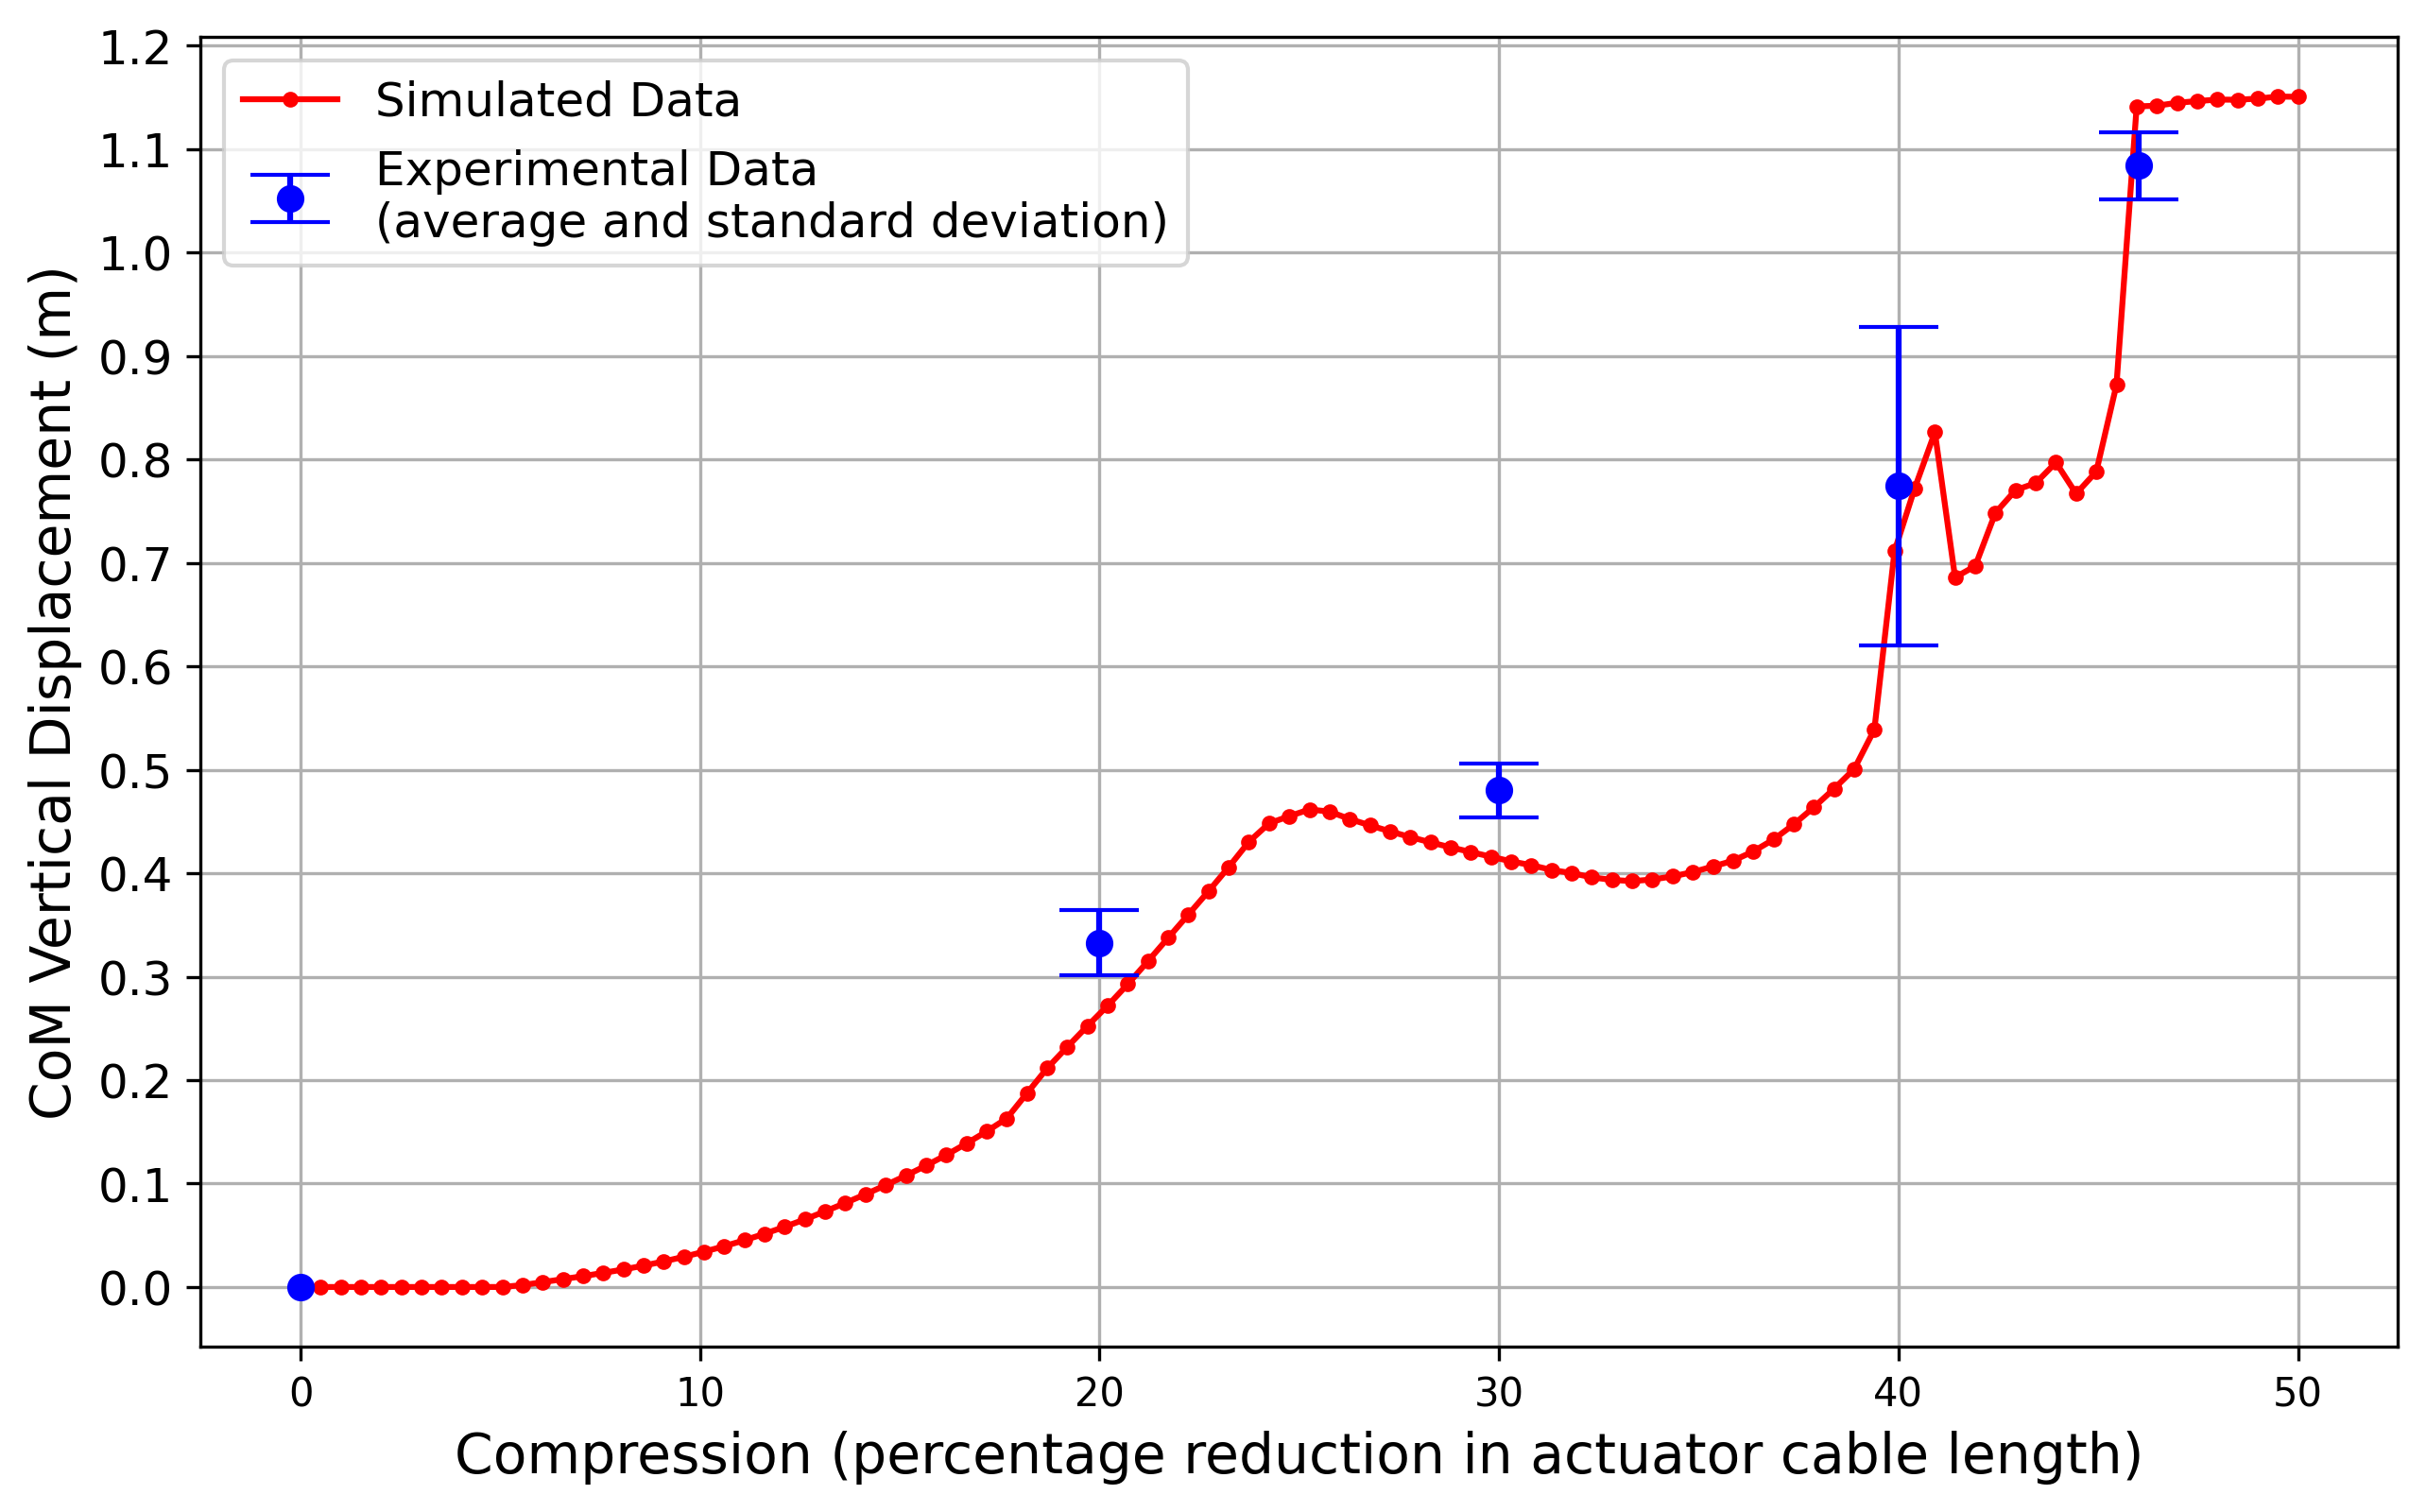

In [8]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(comps, sim_y_displacements, marker='.', color='red', label='Simulated Data')
plt.xlabel('Compression (percentage reduction in actuator cable length)', fontsize=14)
plt.ylabel('CoM Vertical Displacement (m)', fontsize=14)
# plt.title('Max Vertical Displacement During Jump vs Compression Level', fontsize=16)
plt.grid(True)
plt.yticks(np.arange(min(sim_y_displacements), max(sim_y_displacements) + 0.1, 0.1), fontsize=12)

# Convert to lists for plotting
comps_exp = [int(comp.replace('comp', '')) for comp in avg_exp_y_values.keys()]
avg_max_y = list(avg_exp_y_values.values())
std_max_y = list(std_exp_y_values.values())

# Plot the experimental data with error bars
plt.errorbar(comps_exp, 
             avg_max_y, 
             yerr=std_max_y, 
             fmt='o', 
             capsize=10.0, 
             color='blue', 
             label='Experimental Data\n(average and standard deviation)')
plt.legend(fontsize=12)

# Add origin
plt.plot(0, 0, 'bo', label='Origin')

plt.savefig('compress_compare.svg', format='svg')
plt.show()
